# Image processing project4
##Zhongyi Jiang
##Image mosaic

## basic set up


In [1]:
from skimage import io
from skimage import color
from skimage import exposure
from skimage import transform
from skimage.segmentation import flood, flood_fill
import matplotlib.pyplot as plt
import numpy as np 
import os

# Function for converting rgb to grayscale, value range from 0 to 255
def color2gray(img):
    weights = [.3, .6, .1]
    return np.dot(img[...,:3], weights)

# Function for converting rgb to grayscale, value range from 0 to 1
def color2gray_1(img):
    weights = [.3, .6, .1]
    return np.dot(img[...,:3], weights)/256

# helper function
def MSE(img1,img2):
  return ((img1-img2)**2).mean()

# These two padding functions will make the image width and height the same and its value will be 2^n
def zeros_pad(img):
  width = int(np.power(2,np.ceil(np.log2(img.shape[0]))))
  height = int(np.power(2,np.ceil(np.log2(img.shape[1]))))
  # Make square
  if width>height:
    height = width
  else:
    width = height
  shapes = (width,height)
  output = np.zeros(shapes)
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      output[x][y] = img[x][y]
  return output

def average_pad(img):
  width = int(np.power(2,np.ceil(np.log2(img.shape[0]))))
  height = int(np.power(2,np.ceil(np.log2(img.shape[1]))))
  # Make square
  if width>height:
    height = width
  else:
    width = height
  shapes = (width,height)
  avg = img.mean()
  output = np.zeros(shapes)
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      output[x][y] = avg
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      output[x][y] = img[x][y]
  return output

## canvas operation

In [ ]:
# A helper function to add one image to the canvas based on index
def add_image(canvas,x,y,img):
  width = img.shape[0]
  height = img.shape[1]
  for i in range(x-width//2,x+width//2):
    for j in range(y-height//2,y+height//2):
      canvas[i][j] = img[i+width//2-x][j+height//2-y]
  return canvas

# Prune zeros on the final canvas
def cutoff_zeros(img):
  # argwhere will give you the coordinates of every non-zero point
  true_points = np.argwhere(img)
  # take the smallest points and use them as the top left of your crop
  top_left = true_points.min(axis=0)
  # take the largest points and use them as the bottom right of your crop
  bottom_right = true_points.max(axis=0)
  out = img[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
            top_left[1]:bottom_right[1]+1]  # inclusive
  return out
# A helper method copy from https://stackoverflow.com/questions/39465812/how-to-crop-zero-edges-of-a-numpy-array

def expand_canvas(canvas):
  width,height = canvas.shape
  new_canvas = np.zeros((width*2,height*2))
  for i in range(width):
    for j in range(height):
      new_canvas[width//2+i][height//2+j] = canvas[i][j]
  return new_canvas

## read json

The images are ['w0.ppm', 'w1.ppm', 'w2c.ppm', 'w3c.ppm']
There are 3 sets of correspondences
There are 6 correspdondences between image w3c.ppm and image w0c.ppm
[[264 369 257 367 152 146]
 [105  84 252 239 141 242]]
[[134 231 132 231  12  11]
 [ 10   8 128 127  20 110]]
(6, 2)
(6, 2)
There are 12 correspdondences between image w0c.ppm and image w1c.ppm
[[434 451 540 550 542 454 355 402 535 563 565 566]
 [  6 136 125  21 222 216 244 295 216 267 282 306]]
[[ 81 106 210 218 212 110   9  63 203 243 246 248]
 [ 72 227 203  69 328 325 360 418 322 383 399 429]]
(12, 2)
(12, 2)
There are 12 correspdondences between image w0c.ppm and image w2c.ppm
[[256 313 256 313 145 218 145 218  30  16   3   2]
 [164 165 196 192 246 246 342 342 221 362 249 340]]
[[428 489 425 488 302 382 296 376 174 155 140 139]
 [107 109 142 141 195 197 299 300 163 317 192 293]]
(12, 2)
(12, 2)


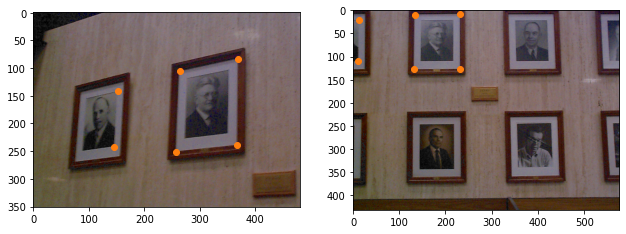

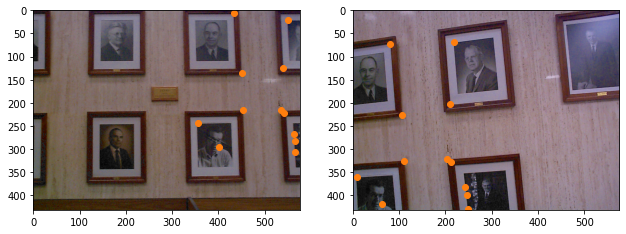

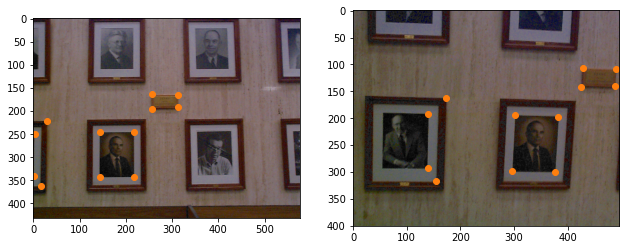

In [ ]:
import json
def read_json(filename):
  with open(filename) as f:
      data = json.load(f)
  print(f"The images are {data['Input files']}")
  corrs = data["Correspondences"]
  print(f"There are {len(corrs)} sets of correspondences")
  source_pair = []
  target_pair = []
  souce_name = []
  target_name = []
  for i in range(len(corrs)):
      print(f"There are {len(corrs[i][0][1])} correspdondences between image {corrs[i][0][0]} and image {corrs[i][1][0]}")
      corra = np.asarray(corrs[i][0][1])
      corrb = np.asarray(corrs[i][1][1])   
      print(corra.T)
      print(corrb.T)
      imageNamea = corrs[i][0][0]
      imageNameb = corrs[i][1][0]
      imageNamea = imageNamea.split('.')
      imageNameb = imageNameb.split('.')
      imagea = io.imread(imageNamea[0]+'.png')
      imageb = io.imread(imageNameb[0]+'.png')
      fig, ax = plt.subplots(1,2)
      fig.set_size_inches(10.5,10.5)
      ax[0].imshow(imagea)
      ax[0].scatter(corra[:,0],corra[:,1],c='#ff7f0e')
      ax[1].imshow(imageb)
      ax[1].scatter(corrb[:,0],corrb[:,1],c='#ff7f0e')
      plt.savefig(str(i)+'.png')

      print(corra.shape)
      print(corrb.shape)
      source_pair.append(corra)
      target_pair.append(corrb)
      souce_name.append(imageNamea[0]+'.png')
      target_name.append(imageNameb[0]+'.png')
      # for testing the progra,. I will just use the first cor
  return source_pair,target_pair,souce_name,target_name
  print(f"The output file is {data['Output file']}")
  
source_pairs,target_pairs,source_names,target_names = read_json("mosaic_params.json")
#print(source_pair,target_pair,source_name,target_name)

## build up matrix, solve svd

In [ ]:
from random import sample 
from random import randint
import numpy as np

# Input pair: x1,y1, source
# Output pair: x'1,y'1, target
def build_up_matrix(source_pair,target_pair,number_of_points):
  N = len(source_pair)
  source_pair = np.array(source_pair)

  source_pair_sample = []
  target_pair_sample = []
  index_array = np.arange(N)
  # if too many coorespondences, do a sampling
  if N>number_of_points:
    for i in range(N-number_of_points):
      remove_index = randint(0, len(source_pair)-1)
      source_pair = np.delete(source_pair,remove_index,axis=0)
      target_pair = np.delete(target_pair,remove_index,axis=0)
    N=number_of_points

  height = N*2
  width = 8

  P = np.zeros((height,width))
  b = np.zeros(height)
  for i in range(N):
    P[i][0] = -1*source_pair[i][0]
    P[i][1] = -1*source_pair[i][1]
    P[i][2] = -1

    P[i+N][3] = -1*source_pair[i][0]
    P[i+N][4] = -1*source_pair[i][1]
    P[i+N][5] = -1
  for i in range(height):
    if i<N:
      P[i][6] = source_pair[i][0]*target_pair[i][0]
      P[i][7] = source_pair[i][1]*target_pair[i][0]
      b[i] = -1*target_pair[i][0]
    else:
      P[i][6] = source_pair[i-N][0]*target_pair[i-N][1]
      P[i][7] = source_pair[i-N][1]*target_pair[i-N][1]
      b[i] = -1*target_pair[i-N][1]
  return np.asarray(P),np.asarray(b)

In [ ]:
def svd(A,b):
  try:
     u,s,vh = np.linalg.svd(A)
  except:
      print("non_invertable")
      empty_np = np.zeros(10)
      return empty_np
  inver_s = np.zeros((vh.shape[0],u.shape[0]))
  for i in range(len(s)):
    inver_s[i][i] = 1/s[i]
    if inver_s[i][i] > 9999999:
        inver_s[i][i] = 0

  inverse_A = np.matmul(np.matrix.transpose(vh) ,np.matmul(inver_s, np.matrix.transpose(u)))
  x = np.matmul(inverse_A,b)
  x = np.append(x,1)
  return x
  

In [ ]:
def bulid_up_edge(p1,p2,points):
  dl = math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
  dx = (p1[0]-p2[0])/dl
  dy = (p1[1]-p2[1])/dl
  k = (p2[1]-p1[1])/(p2[0]-p1[0])
  b = p1[1]-k*p1[0]

  start_x = p1[0]
  start_y = p1[1]
  while abs(start_x-p2[0])>2 or abs(start_y-p2[1])>2 :
    start_x+=dx
    start_y+=dy
    points.append((int(start_x),int(start_y)))


## Perspective transform and interpolation


In [ ]:
def perspective_transform(x,y,p):
  # P is a 3*3 matrix 
  new_x = (p[0][0]*x+p[0][1]*y+p[0][2])/(p[2][0]*x+p[2][1]*y+p[2][2])
  new_y = (p[1][0]*x+p[1][1]*y+p[1][2])/(p[2][0]*x+p[2][1]*y+p[2][2])
  return (new_x,new_y)

In [ ]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)
# copy from https://stackoverflow.com/questions/8661537/how-to-perform-bilinear-interpolation-in-python

## Build up image based on corresponding points. The figure here indicates the general algorthim:


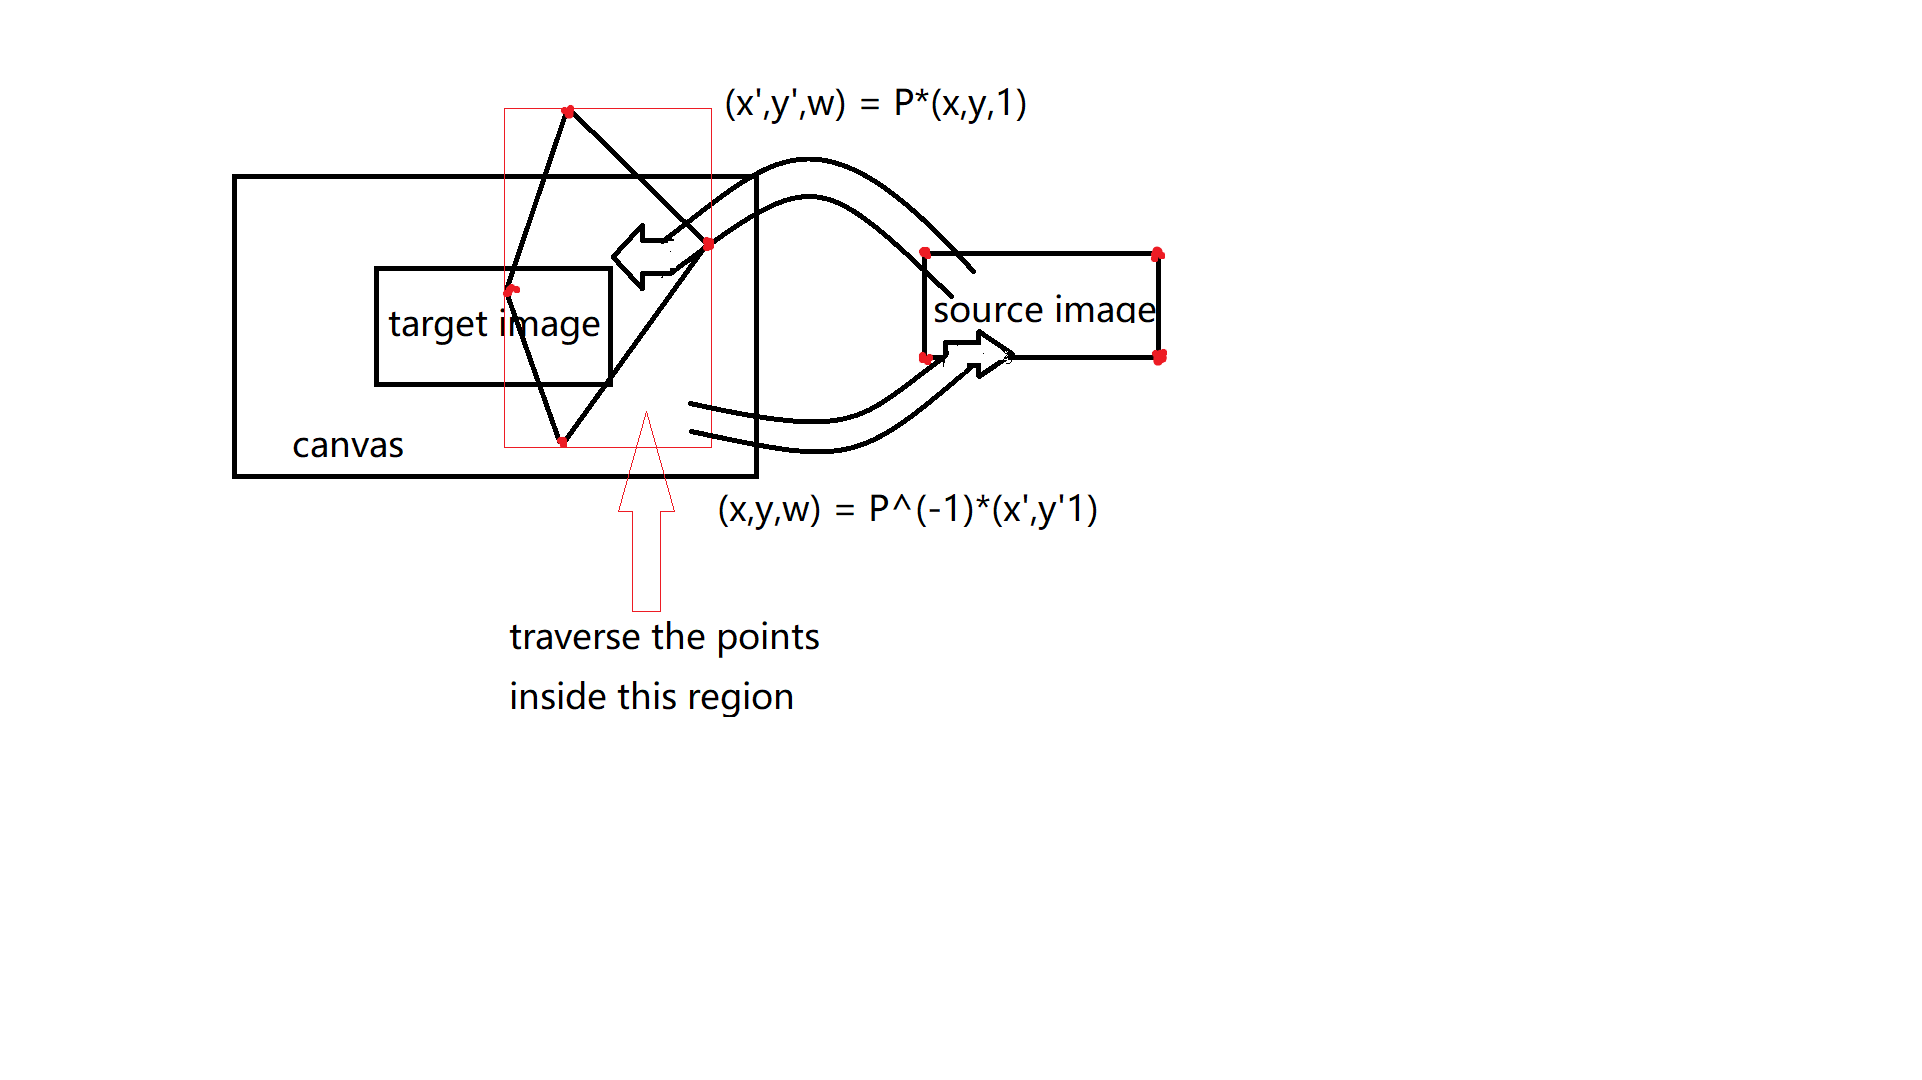

In [ ]:
import math
import scipy.interpolate as interp
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def build_up_image(source_pair,target_pair,source_image,target_image,canvas,number_of_points,p_matrix,equalize = False):
  if not equalize:
    source_image = color2gray(io.imread(source_image))
    target_image = color2gray(io.imread(target_image))
  else:
    source_image = exposure.equalize_hist(color2gray(io.imread(source_image)))
    target_image = exposure.equalize_hist(color2gray(io.imread(target_image)))
  if number_of_points==0:
    number_of_points = len(source_pair)
  # Absx and y should always be the center
  width,height = canvas.shape
  absx = width/2
  absy = height/2
  
  widths,heights = target_image.shape
  width_source,height_source = source_image.shape
  # source_pair/image (source, added on the canvas)
  # target_pair/target image (target, unchanged)

  A,b = build_up_matrix(source_pair,target_pair,number_of_points)
  p = svd(A,b)

  
  # Reshape p into 3*3 matrix and mutiply with the passed in matrix (linked with previous image)
  p = p.reshape((3,3))
  # Mutiple the previous p matrix for sequence cacseding
  p = np.matmul(p_matrix,p)
  
  p_inv = np.linalg.inv(p)

 
  if np.count_nonzero(p==0) == 10:
    # non-invertable case, return an empty p
    return 

  # The limit of source image, used for generating four corners
  x_lim = source_image.shape[1]-1
  y_lim = source_image.shape[0]-1
  # These four points are the corners, in target coordinate
  p1 = perspective_transform(0,0,p)
  p2 = perspective_transform(0,y_lim,p)
  p3 = perspective_transform(x_lim,0,p)
  p4 = perspective_transform(x_lim,y_lim,p)

  # target+offset = canvas

  c1 = int(absx-heights/2) # offset in canvas coordinate
  c2 = int(absy-widths/2)
  
  # Four courners in target coordinate 
  min_x = int(min(p1[0],p2[0],p3[0],p4[0]))
  min_y = int(min(p1[1],p2[1],p3[1],p4[1]))
  max_x = int(max(p1[0],p2[0],p3[0],p4[0]))
  max_y = int(max(p1[1],p2[1],p3[1],p4[1]))

  # Rescale the canvas if not large enough switch to canvas coordinate
  if max_x+c1>=width or max_y+c2>=height or min_x+c1<0 or min_y+c2<0:
      # absx and absy remain the center
      print("enlarge the canvas")
      print(canvas.shape)
      canvas = expand_canvas(canvas)
      print(canvas.shape)
      width,height = canvas.shape
      absx = width/2
      absy = height/2
      c1 = int(absx-heights/2) # offset in canvas coordinate
      c2 = int(absy-widths/2)

  # Sample points

  # X and y are in target coordinate
  for x in range(min_x,max_x):
    for y in range(min_y,max_y):
        # Points in source coordinate (It is a floating point)
        new_y,new_x = perspective_transform(x,y,p_inv)
        if new_x >0 and new_x <width_source-1 and new_y>0 and new_y<height_source-1:
          # These are the four integer points around it
          p1x,p1y = math.floor(new_x),math.floor(new_y)
          p2x,p2y = math.floor(new_x),math.ceil(new_y)
          p3x,p3y = math.ceil(new_x),math.floor(new_y)
          p4x,p4y = math.ceil(new_x),math.ceil(new_y)
          p1 = (p1x,p1y,source_image[p1x][p1y])
          p2 = (p2x,p2y,source_image[p2x][p2y])
          p3 = (p3x,p3y,source_image[p3x][p3y])
          p4 = (p4x,p4y,source_image[p4x][p4y])
          points = [p1,p2,p3,p4]

          if(canvas[y+c2][x+c1]==0):
            canvas[y+c2][x+c1] = bilinear_interpolation(new_x, new_y, points)
          else:
            # blending with the orginal canvas
            canvas[y+c2][x+c1] = 0.5*(bilinear_interpolation(new_x, new_y, points)+canvas[y+c2][x+c1])
  print("Finish adding one image")
  return p,canvas

## Main mosaic image function


In [ ]:
def mosaic_image(source_pairs,target_pairs,source_names,target_namess,equalize = False):
  if equalize:
    target = exposure.equalize_hist(color2gray(io.imread(target_names[0])))
  else:
    # The first image added to the canvas
    target = color2gray(io.imread(target_names[0]))

  # initialize canvas
  initial_size = 5000
  canvas = np.zeros((initial_size,initial_size))

  # add target image to canvas

  canvas = add_image(canvas,initial_size//2,initial_size//2,target) 

  undetermined_list = []

  # Initialize some important parameter
  image_name_table = []
  image_p_matrix_table = []
  utimate_target = target_names[0]
  defualt_p  = np.identity(3)

  # Build up first two images on the canvas
  p,canvas = build_up_image(source_pairs[0],target_pairs[0],source_names[0],target_names[0],canvas,0,defualt_p,equalize)

  # Add to the tables for future operation
  image_name_table.append(source_names[0])
  image_p_matrix_table.append(p)
  image_name_table.append(target_names[0])
  image_p_matrix_table.append(defualt_p)


  
  # Add rest of the images to the canvas
  for i in range(1,len(source_pairs)):
    if target_names[i] in image_name_table:
      index = image_name_table.index(target_names[i])
      p_matrix = image_p_matrix_table[index]

      # In this case, we pass in p matrix for resursion
      p,canvas = build_up_image(source_pairs[i],target_pairs[i],source_names[i],target_names[i],canvas,0,p_matrix,equalize)
      image_name_table.append(source_names[i])
      image_p_matrix_table.append(p)

    elif source_names[i] in image_name_table:
      index = image_name_table.index(source_names[i])
      p_matrix = image_p_matrix_table[index]

      # In this case, we pass in p matrix for resursion
      p,canvas = build_up_image(target_pairs[i],source_pairs[i],target_names[i],source_names[i],canvas,0,p_matrix,equalize)
      image_name_table.append(target_names[i])
      image_p_matrix_table.append(p)

    else: # No connect at this point yet
      undetermined_list.append(i)
  #while(len(undertermined_list)!=0):
  
  canvas = cutoff_zeros(canvas)
  #io.imsave("canvas.png",canvas)
  # exposure.equalize_hist(canvas)
  plt.title("Final mosaic canvas")
  plt.imshow(canvas,cmap="gray")
  plt.show()

The images are ['w0.ppm', 'w1.ppm', 'w2c.ppm', 'w3c.ppm']
There are 3 sets of correspondences
There are 6 correspdondences between image w3c.ppm and image w0c.ppm
[[264 369 257 367 152 146]
 [105  84 252 239 141 242]]
[[134 231 132 231  12  11]
 [ 10   8 128 127  20 110]]
(6, 2)
(6, 2)
There are 12 correspdondences between image w0c.ppm and image w1c.ppm
[[434 451 540 550 542 454 355 402 535 563 565 566]
 [  6 136 125  21 222 216 244 295 216 267 282 306]]
[[ 81 106 210 218 212 110   9  63 203 243 246 248]
 [ 72 227 203  69 328 325 360 418 322 383 399 429]]
(12, 2)
(12, 2)
There are 12 correspdondences between image w0c.ppm and image w2c.ppm
[[256 313 256 313 145 218 145 218  30  16   3   2]
 [164 165 196 192 246 246 342 342 221 362 249 340]]
[[428 489 425 488 302 382 296 376 174 155 140 139]
 [107 109 142 141 195 197 299 300 163 317 192 293]]
(12, 2)
(12, 2)


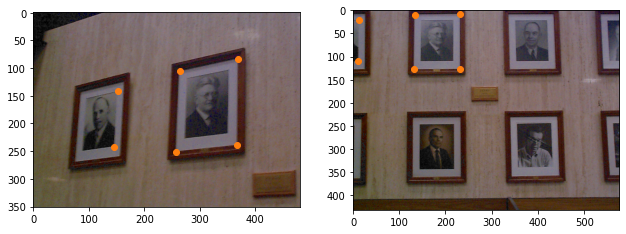

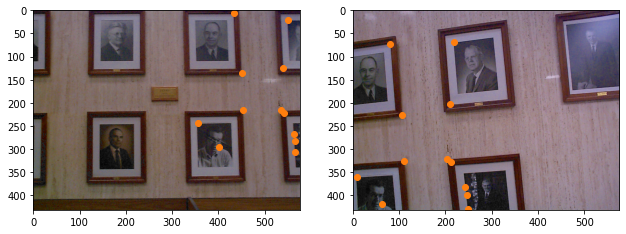

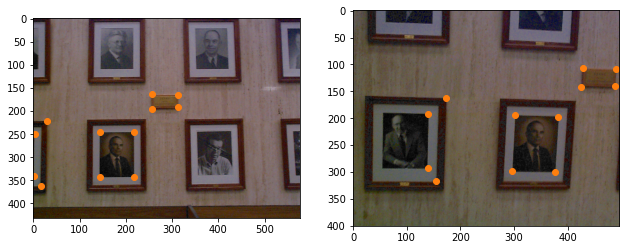

In [ ]:
source_pairs,target_pairs,source_names,target_names = read_json("mosaic_params.json")

## Show the final mosaic canvas using all the points

Finish adding one image
Finish adding one image
Finish adding one image


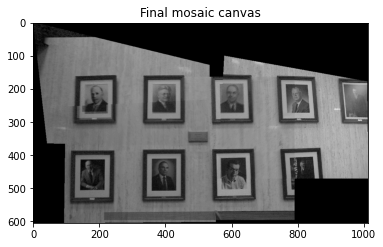

In [ ]:
mosaic_image(source_pairs,target_pairs,source_names,target_names)

The images are ['p1.ppm', 'p2.ppm', 'p3.ppm']
There are 2 sets of correspondences
There are 6 correspdondences between image p1.ppm and image p2.ppm
[[103 172 165 206 238 238]
 [136 173  44 265 212 108]]
[[ 66 111 106 133 149 147]
 [ 89 111  27 165 131  70]]
(6, 2)
(6, 2)
There are 6 correspdondences between image p3.ppm and image p2.ppm
[[ 97  49  42  28 106  64]
 [111  94 120 143 125  73]]
[[215 157 149 133 226 174]
 [113  95 131 164 127  69]]
(6, 2)
(6, 2)


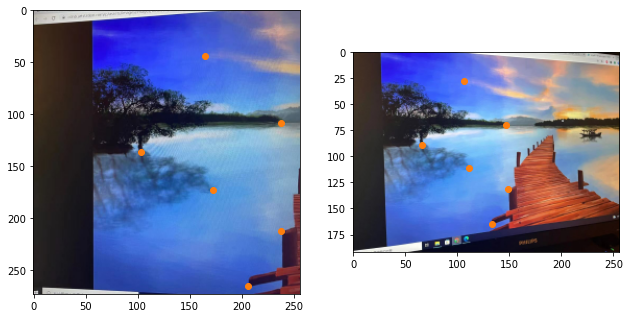

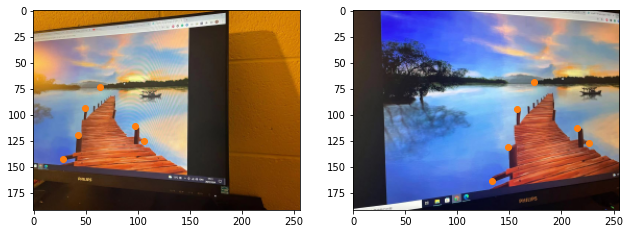

In [ ]:
source_pairs,target_pairs,source_names,target_names = read_json("p_params.json")

Finish adding one image
Finish adding one image


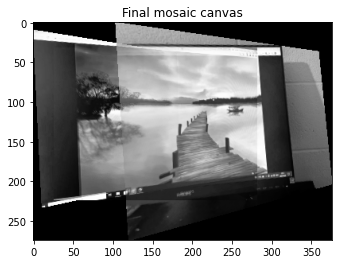

In [ ]:
mosaic_image(source_pairs,target_pairs,source_names,target_names,equalize = True)

Finish adding one image
Finish adding one image


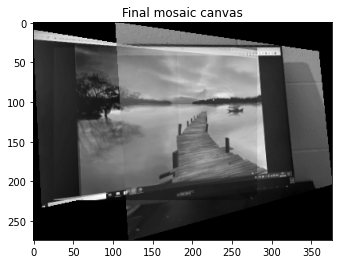

In [ ]:
mosaic_image(source_pairs,target_pairs,source_names,target_names,equalize = False)

The images are ['s1.ppm', 's3.ppm', 's4.ppm']
There are 1 sets of correspondences
There are 9 correspdondences between image s3.ppm and image s4.ppm
[[ 84  40  93 117 119 119   8 122 144]
 [162 167 131  93  65  54 113 138 180]]
[[184 140 186 212 219 221 113 216 235]
 [110 108  85  50  18   5  63  99 145]]
(9, 2)
(9, 2)


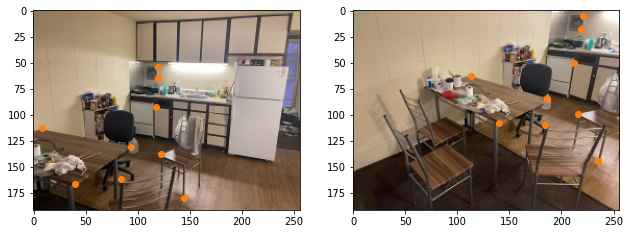

In [ ]:
source_pairs,target_pairs,source_names,target_names = read_json("s_params.json")

Finish adding one image


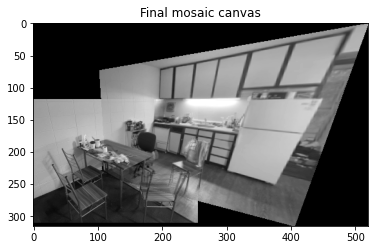

In [ ]:
mosaic_image(source_pairs,target_pairs,source_names,target_names)